In [ ]:
#coding:utf-8

from keras import Input, Model
from keras.layers import Embedding, Dense, Dropout, Bidirectional, CuDNNLSTM
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from keras_preprocessing import sequence
from tensorflow import keras
from tensorflow.python.keras import Input
from tensorflow.python.keras.layers import Concatenate
import numpy
import keras
from keras import backend as K
from keras import activations
from keras.engine.topology import Layer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Embedding, LSTM, Bidirectional
K.clear_session()

In [41]:
class AttentionLayer(Layer):
    def __init__(self, attention_size=None, **kwargs):
        self.attention_size = attention_size
        super(AttentionLayer, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config()
        config['attention_size'] = self.attention_size
        return config
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.time_steps = input_shape[1]
        hidden_size = input_shape[2]
        if self.attention_size is None:
            self.attention_size = hidden_size
            
        self.W = self.add_weight(name='att_weight', shape=(hidden_size, self.attention_size),
                                initializer='uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        self.V = self.add_weight(name='att_var', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        self.V = K.reshape(self.V, (-1, 1))
        H = K.tanh(K.dot(inputs, self.W) + self.b)
        score = K.softmax(K.dot(H, self.V), axis=1)
        outputs = K.sum(score * inputs, axis=1)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

In [42]:
def create_classify_model(max_len, vocab_size, embedding_size, hidden_size, attention_size, class_nums):
	# 輸入層
    inputs = Input(shape=(max_len,), dtype='int32')
    # Embedding層
    x = Embedding(vocab_size, embedding_size)(inputs)
    # BiLSTM層
    x = Bidirectional(LSTM(hidden_size, dropout=0.2, return_sequences=True))(x)
    # Attention層
    x = AttentionLayer(attention_size=attention_size)(x)
    # 輸出層
    outputs = Dense(class_nums, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary() # 輸出模型結構和參數數量
    return model

In [43]:
print ('(1) load texts...')
train_texts = open('data/train_contents.txt').read().split('\n')
train_labels = open('data/train_labels.txt').read().split('\n')
test_texts = open('data/test_contents.txt').read().split('\n')
test_labels = open('data/test_labels.txt').read().split('\n')
all_texts = train_texts + test_texts
all_labels = train_labels + test_labels

(1) load texts...


In [44]:
print ('(2) doc to var...')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np


(2) doc to var...


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)
sequences = tokenizer.texts_to_sequences(all_texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=max_len)
labels = to_categorical(np.asarray(all_labels))
vocab = tokenizer.word_index
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

In [64]:
VOCAB_SIZE = len(vocab)
MAX_LEN = 200
rnn_cell_size = 128
EMBEDDING_SIZE = 100
HIDDEN_SIZE = 64
ATT_SIZE = 50
BATCH_SIZE = 64
EPOCHS = 20
n_classes = ["Oph","Uro","D","Ortho","GYN","P","S","G&H"]
CLASS_NUMS = len(n_classes)+1

In [50]:
print ('(3) split data set...')
p1 = 15000
p2 = -800
x_train = data[:p1]
y_train = labels[:p1]
x_val = data[p1:p2]
y_val = labels[p1:p2]
x_test = data[p2:]
y_test = labels[p2:]

print ('train docs: '+str(len(x_train)))
print ('val docs: '+str(len(x_val)))
print ('test docs: '+str(len(x_test)))



(3) split data set...
train docs: 15000
val docs: 8200
test docs: 800


In [12]:
from mpu.math import argmax
def one_hot2indices(one_hots):
    indices = []
    for one_hot in one_hots:
        indices.append(argmax(one_hot))
    return indices

In [65]:
# 根據參數創建模型
model = create_classify_model(MAX_LEN, VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE, ATT_SIZE, CLASS_NUMS)
# 選擇損失函數和優化函數
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          5119900   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 128)          84480     
_________________________________________________________________
attention_layer_2 (Attention (None, 128)               6500      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1161      
Total params: 5,212,041
Trainable params: 5,212,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 8200 samples
Epoch 1/20
15000/15000 [==============================] - 89s 6ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.4751 - val_accuracy: 0.9033
Epoch 2/20
15000/15000 [==============================] - 89s 6ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.4947 - val_accuracy: 0.8993
Epoch 3/20
15000/15000 [==============================] - 88s 6ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.4525 - val_accuracy: 0.9105
Epoch 4/20
15000/15000 [==============================] - 88s 6ms/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 0.4523 - val_accuracy: 0.9087
Epoch 5/20
15000/15000 [==============================] - 87s 6ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.5414 - val_accuracy: 0.8898
Epoch 6/20
15000/15000 [==============================] - 89s 6ms/step - loss: 0.0058 - accuracy: 0.9979 - val_loss: 0.5182 - val_accuracy: 0.9078
Epoch 7/20
15000/15000 [==============================] - 89s 6ms/ste

In [67]:
def plot_confusion_matrix(cm, n_classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(10, 8)) 
    fig = plt.rcParams['font.size'] = 15
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(n_classes))
    plt.xticks(tick_marks, n_classes, rotation=45)
    plt.yticks(tick_marks, n_classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

(6) testing model...
accuracy:0.96
[[100   0   0   0   0   0   0   0]
 [  0  99   0   0   0   0   1   0]
 [  0   0 101   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0]
 [  0   0   0   0  99   0   0   0]
 [  0   0   0   0   0  99   0   0]
 [  0   0   0   0   0   0 100   0]
 [  0   5   1   1   9   1  14  70]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       100
           2       0.95      0.99      0.97       100
           3       0.99      1.00      1.00       101
           4       0.99      1.00      1.00       100
           5       0.92      1.00      0.96        99
           6       0.99      1.00      0.99        99
           7       0.87      1.00      0.93       100
           8       1.00      0.69      0.82       101

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



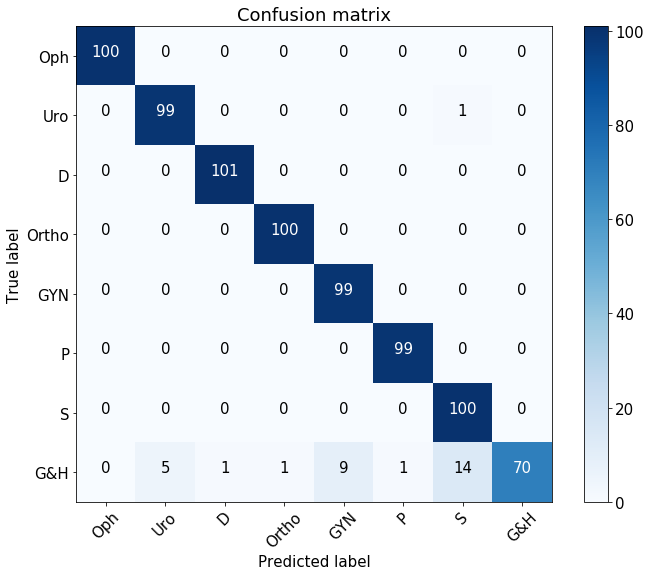

In [68]:
print('(6) testing model...')
from sklearn.metrics import accuracy_score

preds = model.predict(x_test)
y_true = one_hot2indices(y_test)
y_preds = one_hot2indices(preds)
print("accuracy:"+ str(accuracy_score(y_true, y_preds)))

from sklearn import metrics
print(metrics.confusion_matrix(y_true, y_preds))

from sklearn.metrics import classification_report
print(classification_report(y_pred=y_preds, y_true=y_true))


cm = metrics.confusion_matrix(y_true,y_preds)
plot_confusion_matrix(cm, n_classes,
                      title='Confusion matrix')